<a href="https://colab.research.google.com/github/srikarraju/eGrocery_Demand_Prediction/blob/main/NAC_eGrocery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorboardX

     |████████████████████████████████| 122kB 3.9MB/s 


In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
import random
import pandas as pd
from tensorboardX import SummaryWriter

In [ ]:
class EGroceryEnv():

	def __init__(self, df=pd.DataFrame({0:[0]}), products_count=10, features=['a'], shelf_life=[1], wastage_cost=[1], shortage_cost=[1]):
		super(EGroceryEnv, self).__init__()

		self.df = df
		self.products_count = products_count
		self.shelf_life = shelf_life
		self.features = features
		self.wastage_cost = wastage_cost
		self.shortage_cost = shortage_cost
		self.current_step = 0
		self.wastage_track = list([])
		self.shortage_track = list([])
		self.reward_track = list([])

		#variables to track shartage and wastage
		self.shortage = np.array(list([0]*self.products_count))
		self.wastage = np.array(list([0]*self.products_count))

		#Define Stock
		self.stock = list([])
		for i in range(self.products_count):
			self.stock.append([0])
		print(features)


	def _next_observation(self):

		obs  = self.df.loc[self.current_step,self.features]

		st_temp = list([])
		for i in range(len(self.stock)):
			for j in range(1,min(int(self.stock[i][0])+1,5)):
				st_temp.append(self.stock[i][j])
			if(self.stock[i][0]==5):
				st_temp.append(self.stock[i][4])
			elif(self.stock[i][0]<5):
				for j in range(int(self.stock[i][0])+1,6):
					st_temp.append(0)
			else:
				st_temp.append(np.sum(self.stock[i][5:int(self.stock[i][0])+1]))
		obs = list(obs) + list(st_temp) + list(self.shelf_life)
		return obs

	def _take_action(self, action):
		#Add products to the current stocks
		for i in range(self.products_count):
			if(len(self.stock[i])<self.shelf_life[i]):
				for j in range(len(self.stock[i]),int(self.shelf_life[i])):
					self.stock[i].append(0)
			self.stock[i].append(action[i])
			self.stock[i][0]=self.shelf_life[i]



		#Fullfill demand
		prods = ['prod'+str(i) for i in [8,11,15,17,94,95,96,110,112,128]]
		demand = self.df.loc[self.current_step+1,prods]
		for i in range(self.products_count):
			for j in range(1,int(self.stock[i][0])+1):
				if(self.stock[i][j]>=demand[i]):
					self.stock[i][j] = self.stock[i][j] - demand[i]
					demand[i] = 0
					break
				else:
					demand[i] = demand[i] - self.stock[i][j]
					self.stock[i][j] = 0
			if(demand[i]>0):
				self.shortage[i]=demand[i]

		#Update shelf life and find out wastage
		for i in range(self.products_count):
			self.stock[i][0] = self.stock[i][0] -1
			if(self.stock[i][1]>0):
				self.wastage[i] = self.stock[i][1]
			for j in range(1,int(self.stock[i][0])+1):
				self.stock[i][j] = self.stock[i][j+1]
			self.stock[i].pop()


	def step(self, action):
	        # update stock, fullfill demand and calculate shortage and wastage
		quantity = [6, 10, 15, 4, 6, 2, 7, 50, 2, 30]
		action1 = [0]*self.products_count
		for i in range(len(action)):
			action1[i] = action[i]*quantity[i]
		self._take_action(action1)
		self.action = action

		#increment step
		self.current_step += 1


		reward = -1*(np.matmul(self.wastage_cost,self.wastage.transpose())+np.matmul(self.shortage_cost,self.shortage.transpose()))
		self.reward = reward
		done = (self.current_step < 0) or (self.current_step > self.df.shape[0]-2)

		obs = self._next_observation()

		self.wastage_track.append(np.sum(self.wastage))
		self.shortage_track.append(np.sum(self.shortage))
		self.reward_track.append(np.abs(self.reward))


		self.shortage = np.array(list([0]*self.products_count))
		self.wastage = np.array(list([0]*self.products_count))

		return obs, np.sum(self.reward), done, {}

	def reset(self):
		# Reset the state of the environment to an initial state
		self.current_step = 0
		self.shortage = np.array(list([0]*self.products_count))
		self.wastage = np.array(list([0]*self.products_count))
		self.stock = list([])
		for i in range(self.products_count):
			self.stock.append([0])

		#print(len(self.features),products_count)
		#print(self.features)
		return [0]*len(self.features) + [0]*6*self.products_count

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RL_Project/Models/ppo_based/PPOBased/data/final_data_trainx.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RL_Project/Models/ppo_based/PPOBased/data/final_data_testx.csv')

products_count = 10

avg_f7 = ['prod'+str(i)+'avg7' for i in [8,11,15,17,94,95,96,110,112,128]]
avg_f15 = ['prod'+str(i)+'avg15' for i in [8,11,15,17,94,95,96,110,112,128]]
avg_f30 = ['prod'+str(i)+'avg30' for i in [8,11,15,17,94,95,96,110,112,128]]

features = ['month', 'monthday', 'weekday'] + avg_f7 + avg_f15 + avg_f30

print(features)

shelf_life = np.array([4, 3, 5, 10, 7, 2, 1, 3, 8, 6], dtype=np.float32)

wastage_cost = np.array([1]*products_count, dtype=np.float16)
shortage_cost = np.array([1]*products_count, dtype=np.float16)

action_std = 0.1
eps_clip = 0.2
gamma = 0.99

lr = 0.0001
betas = (0.9, 0.999)
K_epochs = 5

update_timestep = 20
time_step=0
running_reward = 0

state_dim = len(features) + 6*products_count
action_dim = products_count

env = EGroceryEnv(df_train, products_count, features, shelf_life, wastage_cost, shortage_cost)

writer = SummaryWriter()

Total_reward = []


['month', 'monthday', 'weekday', 'prod8avg7', 'prod11avg7', 'prod15avg7', 'prod17avg7', 'prod94avg7', 'prod95avg7', 'prod96avg7', 'prod110avg7', 'prod112avg7', 'prod128avg7', 'prod8avg15', 'prod11avg15', 'prod15avg15', 'prod17avg15', 'prod94avg15', 'prod95avg15', 'prod96avg15', 'prod110avg15', 'prod112avg15', 'prod128avg15', 'prod8avg30', 'prod11avg30', 'prod15avg30', 'prod17avg30', 'prod94avg30', 'prod95avg30', 'prod96avg30', 'prod110avg30', 'prod112avg30', 'prod128avg30']
['month', 'monthday', 'weekday', 'prod8avg7', 'prod11avg7', 'prod15avg7', 'prod17avg7', 'prod94avg7', 'prod95avg7', 'prod96avg7', 'prod110avg7', 'prod112avg7', 'prod128avg7', 'prod8avg15', 'prod11avg15', 'prod15avg15', 'prod17avg15', 'prod94avg15', 'prod95avg15', 'prod96avg15', 'prod110avg15', 'prod112avg15', 'prod128avg15', 'prod8avg30', 'prod11avg30', 'prod15avg30', 'prod17avg30', 'prod94avg30', 'prod95avg30', 'prod96avg30', 'prod110avg30', 'prod112avg30', 'prod128avg30']


In [ ]:
class policy_net(nn.Module):
  def __init__(self,state_dim,hidden_dim,action_dim):
    super(policy_net,self).__init__()
    self.h = nn.Linear(state_dim,hidden_dim)
    self.out1 = nn.Linear(hidden_dim,hidden_dim)
    self.out2 = nn.Linear(hidden_dim,action_dim)
    self.action_var = torch.Tensor([0.1]*10)

  def forward(self,x):
    x = F.relu(self.h(x))
    x = F.relu(self.out1(x))
    x = F.softmax(self.out2(x),dim=1)
    return x

  def act(self, state,action_mean):
    state = torch.Tensor(state)
    cov_mat = torch.diag(self.action_var)

    dist = MultivariateNormal(action_mean, cov_mat)
    action = dist.sample()
    action_logprob = dist.log_prob(action)

    return action.detach(),action_logprob

In [ ]:
weights_v = np.zeros(93,dtype=float)
policy = policy_net(93,512,products_count)
optimizer = torch.optim.SGD(policy.parameters(),lr=1)

In [ ]:
# ALGORITHM 1
alpha_0, beta_0, gamma, epsilon = 0.1, 0.01, 0.95, 0.1
alpha_c, beta_c = 1000, 100000
t = 0
n_episode = 0
actions_list = []
avg_reward = 0

while n_episode <=10000:
  rewards,states,actions = [],[],[]
  state = env.reset()
  total_reward = 0
  while True:
    action_mean = policy(torch.tensor(state).unsqueeze(0).float()).squeeze(0)
    #print(action_mean)
    action,action_logprob = policy.act(state,action_mean)
    new_state, reward, done,info = env.step(action)


    value_curr = np.dot(weights_v,state)
    value_next = np.dot(weights_v,new_state)

    beta = (beta_0 * beta_c) / (beta_c + t)
    alpha = (alpha_0 * alpha_c) / (alpha_c + t**(2/3))

    avg_reward = (1 - alpha*gamma)* avg_reward + gamma * alpha* reward
    td_error = reward + value_curr - value_next - avg_reward

    weights_v += alpha*abs(td_error)/td_error * np.asarray(state)

    policy_net_loss = -beta*abs(td_error)/td_error*action_logprob
    optimizer.zero_grad()
    policy_net_loss.backward()
    optimizer.step()

    total_reward += reward

    state = new_state
    if done == 1:
      break
  print("Epoch:",n_episode,"Reward:",total_reward)

  n_episode += 1

Epoch: 0 Reward: -196971.0
Epoch: 1 Reward: -196682.0
Epoch: 2 Reward: -197426.0
Epoch: 3 Reward: -197300.0
Epoch: 4 Reward: -197120.0
Epoch: 5 Reward: -196552.0
Epoch: 6 Reward: -197233.0
Epoch: 7 Reward: -197936.0
Epoch: 8 Reward: -196831.0
Epoch: 9 Reward: -197195.0
Epoch: 10 Reward: -196042.0
Epoch: 11 Reward: -197039.0
Epoch: 12 Reward: -196984.0
Epoch: 13 Reward: -196956.0
Epoch: 14 Reward: -197372.0
Epoch: 15 Reward: -197041.0
Epoch: 16 Reward: -197275.0
Epoch: 17 Reward: -196944.0
Epoch: 18 Reward: -196637.0
Epoch: 19 Reward: -197431.0
Epoch: 20 Reward: -197497.0
Epoch: 21 Reward: -197802.0
Epoch: 22 Reward: -197565.0
Epoch: 23 Reward: -197156.0
Epoch: 24 Reward: -196954.0
Epoch: 25 Reward: -196182.0
Epoch: 26 Reward: -196467.0
Epoch: 27 Reward: -197315.0
Epoch: 28 Reward: -196803.0
Epoch: 29 Reward: -197292.0
Epoch: 30 Reward: -197718.0
Epoch: 31 Reward: -196121.0
Epoch: 32 Reward: -196873.0
Epoch: 33 Reward: -196675.0
Epoch: 34 Reward: -197804.0
Epoch: 35 Reward: -197437.0
Ep

KeyboardInterrupt: ignored

In [ ]:
#ALGORITHM 2
alpha_0, beta_0, gamma, epsilon = 0.1, 0.01, 0.95, 0.1
alpha_c, beta_c = 1000, 1000
t = 0
n_episode = 0
avg_reward = 0
lamda = 0.9

fischer_inv = 1.5*np.eye(6)
state_features = generate_state_features(grid_dim)

while n_episode <=15000:
  rewards,states,actions = [],[],[]
  state = 0
  episode_len = 0
  t = 0

  while episode_len<100:
    episode_len += 1
    t += 1
    state_action_features = generate_state_action_features(state_features[state],d,num_actions)

    probs = np.dot(state_action_features,weights_p)
    probs -= probs.max()
    probs = np.exp(np.clip(probs/epsilon, -500, 500))
    probs /= probs.sum()
    probs2 = probs.cumsum()
    action = np.where(probs2 >= np.random.random())[0][0]

    new_state, reward, done = env.step(state,action)


    value_curr = np.dot(weights_v,state_features[state])
    value_next = np.dot(weights_v,state_features[state])

    beta = (beta_0 * beta_c) / (beta_c + t)
    alpha = (alpha_0 * alpha_c) / (alpha_c + t**(2/3))

    avg_reward = (1 - alpha*gamma)*avg_reward + alpha*gamma * reward

    td_error = reward + value_next - value_curr - avg_reward

    weights_v += alpha * td_error * np.asarray(state_features[state])

    grad_prob = probs[action]*(1-probs[action])*state_action_features[action]

    Gt_psi_dot = np.dot(fischer_inv, grad_prob)
    fischer_inv -= (0.00001*alpha * np.outer(Gt_psi_dot,Gt_psi_dot) ) / (1 - 0.00001*alpha + 0.00001*alpha * np.dot(Gt_psi_dot,grad_prob))
    fischer_inv /= (1 - 0.00001*alpha)

    weights_p += 0.1*beta * td_error * np.dot(fischer_inv,grad_prob)

    states.append(state)
    actions.append(action)
    rewards.append(reward)

    state = new_state
    if done==1:
      break

  returns.append(np.sum(rewards))
  if n_episode%100==0:
    print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.mean(returns)))
  rewards2.append(np.mean(returns))
  n_episode += 1

In [ ]:
env2 = EGroceryEnv(df_test, products_count, features, shelf_life, wastage_cost, shortage_cost)
state = env2.reset()
for step in range(0,30):
  state = np.asarray(state,dtype=float)
  action_mean = policy(torch.tensor(state).unsqueeze(0).float()).squeeze(0)
  action,action_logprob = policy.act(state,action_mean)
  print(action)
  next_state,reward,done,_ = env2.step(action)
  #print(reward)
  state = next_state
print(env2.reward_track)

['month', 'monthday', 'weekday', 'prod8avg7', 'prod11avg7', 'prod15avg7', 'prod17avg7', 'prod94avg7', 'prod95avg7', 'prod96avg7', 'prod110avg7', 'prod112avg7', 'prod128avg7', 'prod8avg15', 'prod11avg15', 'prod15avg15', 'prod17avg15', 'prod94avg15', 'prod95avg15', 'prod96avg15', 'prod110avg15', 'prod112avg15', 'prod128avg15', 'prod8avg30', 'prod11avg30', 'prod15avg30', 'prod17avg30', 'prod94avg30', 'prod95avg30', 'prod96avg30', 'prod110avg30', 'prod112avg30', 'prod128avg30']
tensor([-0.0756,  0.4147,  0.1228,  0.2353,  0.4955, -0.6787, -0.5794, -0.0606,
        -0.0388, -0.3917])
tensor([ 0.1463, -0.1173, -0.1332, -0.0124, -0.3296, -0.1962, -0.6456, -0.6367,
        -0.3051,  1.4807])
tensor([-0.4096, -0.2037, -0.3549,  0.2600,  0.0032,  0.2689,  0.1277,  0.1420,
         0.2613,  1.5361])
tensor([-0.5405, -0.6730, -0.2119, -0.0679,  0.3748, -0.6348, -0.0166,  0.0638,
        -0.0400,  1.0583])
tensor([ 0.2666, -0.1917, -0.2268,  0.2777,  0.3695, -0.0730, -0.0427, -0.0506,
         0.35

In [ ]:
print(sum(env2.reward_track)/len(env2.reward_track))
print(env2.wastage_track)
print(env2.shortage_track)
print(sum(env2.wastage_track)+ sum(env2.shortage_track))

227.36666666666667
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[334, 273, 225, 177, 200, 250, 158, 286, 251, 141, 165, 229, 222, 215, 192, 247, 260, 207, 261, 238, 242, 182, 217, 145, 198, 234, 281, 315, 235, 241]
6821


31
31
31


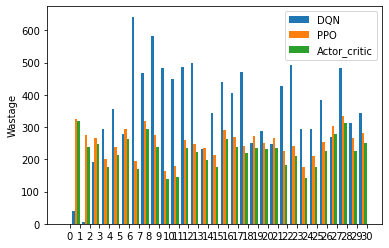

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 31
DQN_wastage = (0,41,5,191,295,357,279,642,468,583,483,449,485,498,233,344,439,404,470,250,289,246,426,493,295,293,384,270,483,313,345)
Actor_critic = (0,318,237,247,175,212,262,170,293,239,138,145,235,222,199,176,263,238,221,236,231,236,183,211,142,176,225,278,313,227,252)
PPO = (0,324,275,267,200,238,294,195,320,275,164,180,261,247,235,212,290,268,240,272,250,266,227,242,175,210,254,302,335,266,283)
print(len(DQN_wastage))
print(len(Actor_critic))
print(len(PPO))

ind = np.arange(N)
ind = 2*ind
width = 0.5
plt.bar( ind,DQN_wastage, width, label='DQN')
plt.bar(ind + width, PPO, width,label='PPO')
plt.bar(ind + width + width, Actor_critic, width,label='Actor_critic')

plt.ylabel('Wastage')
#plt.title('Scores by group and gender')

plt.xticks(ind + 5*width / 2, np.arange(N))
plt.legend(loc='best')
plt.savefig('Shortage.png')